In [1]:
'''
(C) 2023 Renata Wong

Electronic structure problem with classical shadows, as presented in https://arxiv.org/abs/2103.07510
This code uses Qiskit as platform. 
The molecule tested is H2.
The shadow is vanilla, i.e. uses randomized basis change operations. 
'''

import time
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, execute
from qiskit_aer import QasmSimulator

from qiskit.quantum_info import SparsePauliOp

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

from qiskit.circuit.library import TwoLocal

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA

# Estimator primitive is based on the Statevector construct = algebraic simulation
from qiskit.primitives import Estimator 
from qiskit.utils import algorithm_globals

from predicting_quantum_properties.data_acquisition_shadow import randomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp

# taking care of deprecation issues
import qiskit_nature
qiskit_nature.settings.use_pauli_sum_op = False
import h5py
H5PY_DEFAULT_READONLY=1





driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="6-31g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

problem = driver.run()

hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()

mapper = BravyiKitaevMapper()
bkencoded_hamiltonian = mapper.map(second_q_op)

print(bkencoded_hamiltonian)

/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
def process_hamiltonian(hamiltonian, derandomize = False):

    hamiltonian_observables = []
    hamiltonian_coefficients = []

    for observable in hamiltonian.paulis:
        op_list = []
        for op_index, pauli_op in enumerate(observable):
            pauli_op = str(pauli_op)
            if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
                op_list.append((pauli_op, op_index))
        hamiltonian_observables.append(op_list)
    
    hamiltonian_coefficients = hamiltonian.coeffs.real
    
    system_size = len(hamiltonian_observables[0])

    # removing all occurrences of Pauli-I, for all-Pauli-I there is an empty list left
    # these observables are needed for estimate_exp()
    observables_xyze = []

    for observable in hamiltonian_observables:
        XYZE = []
        for pauli in observable:
            if pauli[0] != 'I':
                XYZE.append(pauli)
        observables_xyze.append(XYZE)   
    
    # derandomisation procedure requires that coefficients are non-negative
    if derandomize == True:
        absolute_coefficients = [abs(coeffcient) for coeffcient in hamiltonian_coefficients]

        # removing the empty list as well
        # these observables are needed for derandomisation procedure
        observables_xyz = []
        for idx, observable in enumerate(observables_xyze):
            if observable:
                observables_xyz.append(observable)
            else:
                absolute_coefficients.pop(idx)
        
        return system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients
    
    return system_size, observables_xyze, hamiltonian_coefficients



# process the Hamiltonian to obtain properly formatted data
hamiltonian_data = process_hamiltonian(bkencoded_hamiltonian, derandomize = False)
system_size, observables_xyze, hamiltonian_coefficients = hamiltonian_data

#print('HAMILTONIAN\n', observables_xyze)

In [3]:
'''
VARIATIONAL ANSATZ
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 5
ansatz = TwoLocal(num_qubits=system_size, reps=reps, rotation_blocks=['ry', 'rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=False)
ansatz.decompose().draw('mpl')






def basis_change_circuit(pauli_op):

    #   Generating circuit with just the basis change operators
    #
    #       pauli_op: n-qubit Pauli operator

    basis_change = QuantumCircuit(ansatz.num_qubits, ansatz.num_qubits)

    for idx, op in enumerate(pauli_op):
        
        if op == 'X':
            basis_change.h(idx)
        if op == 'Y':
            basis_change.h(idx)
            basis_change.p(-np.pi/2, idx)
            
    return basis_change

    
    


def ground_state_energy_from_shadow(operators, params):
    
    backend = QasmSimulator(method='statevector', shots=1)
    
    pauli_op_dict = Counter(tuple(x) for x in operators)    
    

    shadow = []
    for pauli_op in pauli_op_dict:
        
        qc = ansatz.bind_parameters(params)
        qc = qc.compose(basis_change_circuit(pauli_op))                                  
        qc.measure(reversed(range(system_size)), range(system_size))                      
        
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()    # given in order q0 q1 ... qn-1 after register reversal in qc.measure
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values

                output_str = list(count)   
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                
                shadow.append(snapshot)
    

    expectation_value = 0.0
    for term, weight in zip(observables_xyze, hamiltonian_coefficients):
        
        sum_product, match_count = estimate_exp(shadow, term)
        
        if match_count != 0:
            expectation_value += (weight * sum_product / match_count)

    return expectation_value

In [5]:
'''
Running VQE on the Hamiltonian obtained from PySCFDriver using Statevector simulator (Estimator primitive)
'''

estimator = Estimator()
# If shots = None, it calculates the exact expectation values. Otherwise, it samples from normal distributions 
# with standard errors as standard deviations using normal distribution approximation.
estimator.set_options(shots = None)
vqe_solver = VQE(estimator, ansatz, SPSA(maxiter=3000))

calc = GroundStateEigensolver(mapper, vqe_solver)
result = calc.solve(problem)
print(result.raw_result)

{   'aux_operators_evaluated': {   'AngularMomentum': (   0.007764708324754052,
                                                          {}),
                                   'Magnetization': (   -0.0025406890587447717,
                                                        {}),
                                   'ParticleNumber': (2.001635264465879, {}),
                                   'XDipole': (0.0, {}),
                                   'YDipole': (0.0, {}),
                                   'ZDipole': (1.4152393707145512, {})},
    'cost_function_evals': 6000,
    'eigenvalue': -1.8465447205107646,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fc9e9d0cee0>,
    'optimal_parameters': {   ParameterVectorElement(θ[85]): 4.469608360307824,
                              ParameterVectorElement(θ[86]): 3.1226948341703764,
                              ParameterVectorElement(θ[87]): 4.700285265489391,
                              Paramet

NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -0.6848293565636313
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -0.9871316019725636
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -0.9268144454735621
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.2435658963542282
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -0.9977935203840707
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -1.037484975805596
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.0014001885180845
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -0.7700156020436677
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -0.6380979639335005
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -1.035074047518656
50 | Counter({('X', 'X', 'Z', 'Z', 'X', 'Y', 'Y', 'Y'): 1, ('Y', 'Y', 'X', 'Z', 'X', 'Z', 'Z', 'Y'): 1, ('X', 'Y', 'X', 'Z', 'X', 'Y', 'Y', 'Y'): 1, ('Y', 'X', 'Y', 'X', 'Y', 'Z', 'Y', 'Y'): 1, ('Y', 'Z', 'Z', 'Z', 'Z', 'X', 'X', 'X'): 1, ('X', 'Z', 'Y', 'X', 'Y', 'X', 'X', 'Z'): 1, ('Y', 'Z', 'X', 'X', 'Z', 'Z', 

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.7841637286923613
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.8233376076903176
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.9009756668349362
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.6187073881045553
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.98191372333514
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -1.7883418025784417
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.6832284257606194
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -1.9484481640370233
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -1.6970304485414276
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -1.676506327516247
500 | Counter({('X', 'Y', 'Y', 'Z', 'X', 'Z', 'Z', 'X'): 2, ('Y', 'Y', 'Y', 'X', 'X', 'X', 'X', 'X'): 2, ('Y', 'Z', 'X', 'Y', 'Z', 'Z', 'X', 'X'): 2, ('X', 'Y', 'X', 'X', 'Y', 'X', 'Y', 'Y'): 2, ('X', 'Y', 'Y', 'X', 'Y', 'Z', 'Z', 'Z'): 2, ('Z', 'Y', 'Y', 'Z', 'Y', 'Z', 'Z', 'X'): 2, ('Z', 'Y', 'Z', 'X', 'Y', 'Y', 'Y', 'Y'): 2, ('Y', 'Y', 'Y', 'X', 'Z', 'Z', 'X', 'Z'): 2, ('Z', 'Y

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.6624511278180079
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.7786322188577428
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.776051849483616
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.8763110867233157
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.6514024330337627
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -1.7343801109608676
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.620443797771803
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -1.860153076062687
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -2.0295323649049646
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -1.8900303726172234
750 | Counter({('Z', 'Z', 'Y', 'Z', 'Y', 'X', 'Z', 'Y'): 2, ('Y', 'X', 'Y', 'X', 'Z', 'Y', 'Y', 'Y'): 2, ('Z', 'X', 'Z', 'Y', 'Y', 'Y', 'Y', 'X'): 2, ('Z', 'X', 'X', 'Z', 'Z', 'Z', 'Y', 'X'): 2, ('X', 'X', 'Y', 'X', 'Z', 'Z', 'X', 'Y'): 2, ('Z', 'Y', 'Y', 'X', 'Y', 'X', 'Y', 'Z'): 2, ('Y', 'X', 'Z', 'Y', 'Y', 'Y', 'Z', 'Z'): 2, ('Z', 'Y', 'X', 'Z', 'Y', 'Z', 'X', 'Z'): 2, ('X', 'Y

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.847100837494489
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.831902206358051
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.843655833747297
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.8986812750601072
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.843288244487805
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -1.6721264919770145
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.8338336408932674
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -1.9253635905723387
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -1.9421848762738814
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -2.0060184335968665
1000 | Counter({('Z', 'Z', 'Z', 'Y', 'Y', 'X', 'X', 'Y'): 3, ('Z', 'X', 'Y', 'X', 'Y', 'Z', 'Y', 'Y'): 3, ('Y', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'X'): 3, ('X', 'X', 'X', 'Z', 'Z', 'Y', 'Z', 'X'): 3, ('Y', 'Z', 'Y', 'Y', 'Y', 'X', 'Z', 'X'): 2, ('Y', 'X', 'X', 'Y', 'Y', 'Z', 'Z', 'Y'): 2, ('Y', 'X', 'Y', 'Z', 'Y', 'Z', 'X', 'X'): 2, ('Y', 'Z', 'Z', 'Y', 'Z', 'Y', 'X', 'X'): 2, ('Y', 'Z

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.8208288355342437
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.9617940692796998
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.6416770238620912
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -2.062335597754327
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -2.063855388651397
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -1.9210382901821095
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.7395683403994888
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -2.0614813008915993
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -1.920439746461389
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -1.731365359722246
1250 | Counter({('X', 'X', 'Z', 'Z', 'Y', 'X', 'X', 'X'): 3, ('Y', 'Z', 'Z', 'Y', 'X', 'Y', 'X', 'Y'): 3, ('Z', 'Z', 'X', 'Z', 'Y', 'Z', 'Z', 'X'): 3, ('X', 'Y', 'X', 'Z', 'Z', 'X', 'Z', 'Z'): 3, ('Y', 'Z', 'Z', 'Z', 'Y', 'X', 'Y', 'Z'): 3, ('X', 'X', 'Y', 'Z', 'Z', 'Y', 'X', 'Z'): 2, ('X', 'X', 'Y', 'Y', 'Z', 'Y', 'Y', 'Z'): 2, ('Z', 'X', 'Z', 'Z', 'X', 'Z', 'X', 'X'): 2, ('Z', 'Z

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.855032344367223
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.9283589639451437
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.930400512995629
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.9202706893553578
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.6934113806505484
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -1.9441278241926294
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.8308297876710578
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -1.9296473980059627
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -1.7106172052657018
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -1.8612473585117688
1500 | Counter({('Y', 'Y', 'Y', 'Y', 'X', 'Y', 'X', 'Z'): 4, ('X', 'Z', 'X', 'X', 'Z', 'Y', 'Z', 'Y'): 3, ('Z', 'Z', 'Y', 'X', 'Z', 'X', 'Z', 'Z'): 3, ('Z', 'X', 'Z', 'Y', 'Y', 'Z', 'Y', 'Y'): 3, ('Z', 'Y', 'X', 'Y', 'X', 'X', 'Z', 'X'): 3, ('Y', 'Y', 'Z', 'X', 'Y', 'X', 'Z', 'Z'): 3, ('Y', 'X', 'Y', 'Y', 'Z', 'Y', 'Z', 'Z'): 3, ('Y', 'Y', 'X', 'Y', 'Z', 'X', 'Y', 'Z'): 3, ('Y', 

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.835428537254075
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.6439825615143504
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.8367157825554188
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.8824505747101172
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.5982487105963148
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -1.8266174055489708
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.8010534321618892
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -1.7712718655535935
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -1.851904355829716
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -1.6845390266009648
1750 | Counter({('Z', 'Z', 'Y', 'X', 'Y', 'Z', 'Z', 'Z'): 3, ('Z', 'Y', 'Z', 'Z', 'X', 'Y', 'Y', 'Y'): 3, ('Y', 'Z', 'X', 'Z', 'Z', 'Z', 'Z', 'Y'): 3, ('Y', 'X', 'Y', 'X', 'Z', 'X', 'Y', 'Z'): 3, ('X', 'Z', 'Y', 'X', 'X', 'Z', 'X', 'Y'): 3, ('Z', 'X', 'Z', 'Z', 'X', 'X', 'Y', 'Y'): 3, ('Y', 'X', 'X', 'Z', 'Y', 'X', 'Y', 'Y'): 3, ('X', 'Y', 'X', 'Y', 'Z', 'Z', 'X', 'Y'): 3, ('Y', 

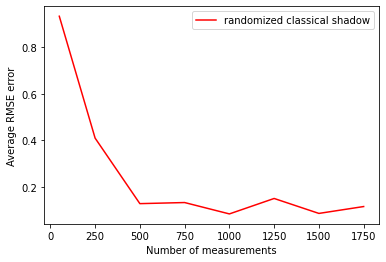

In [8]:
'''
EXPERIMENTS
'''

start_time = time.time()
rmse_errors = []




print('NUMBER OF OPERATORS | RANDOMIZED OPERATORS | AVERAGE RMSE ERROR\n')
measurement_range = [50, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:   
    
    randomized_basis_change = randomized_classical_shadow(num_operators, system_size)

    tuples = (tuple(pauli) for pauli in randomized_basis_change)
    counts = Counter(tuples)
    
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        
        expectation_value = ground_state_energy_from_shadow(randomized_basis_change, result.raw_result.optimal_point)
        expectation_values.append(expectation_value)
                
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, expectation_value))


    rmse_randomised_cs = np.sqrt(np.sum([(expectation_values[i] - result.raw_result.optimal_value)**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_randomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_randomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='randomized classical shadow')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)